In [1]:
% pylab inline
import theano
import theano.tensor as T
import numpy as np
import os
import time 
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave, imread, imresize
import my_net
from my_net import load_saved_model
from project_ulti import *

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.
/Users/xikai_chen/anaconda/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:

root_dir = os.path.abspath('.')

base_image_path = os.path.join(root_dir, 'base_image.jpg')
ref_image_path = os.path.join(root_dir, 'reference_image.jpg')

In [3]:
img_nrows = 32
img_ncols = 32
style_weight = 0.9
content_weight = 0.000005

In [4]:
base_img = preprocess_image(base_image_path)
ref_img = preprocess_image(ref_image_path)
base_image=T.tensor4('base_image')
base_image=base_img
ref_image=T.tensor4('reference_image')
ref_image=ref_img



In [5]:
rng = numpy.random.RandomState(23455)
W_values = numpy.asarray(
                rng.normal(size=(1,3,img_nrows, img_ncols)),dtype=theano.config.floatX)

final_image= T.tensor4('final_image')


In [6]:
p1=load_saved_model(input=base_image)
p2=load_saved_model(input=final_image)
p3=load_saved_model(input=ref_image)


loading started
loading complete
... building the model
loading started
loading complete
... building the model
loading started
loading complete
... building the model


In [7]:
outputs_dict = {'block1_conv1':[p1[0],p2[0],p3[0]],'block1_conv2':[p1[1],p2[1],p3[1]],'block1_conv3':[p1[2],p2[2],p3[2]]}


In [8]:
def content_loss(base, final):
    return T.sum(T.square(final - base))
    
def style_loss(style, final):
    S = gram_matrix(style)     #style/final feature [3,400,400]
    F = gram_matrix(final)
    channels = 3    #error(style - final)
    size = img_nrows * img_ncols
    return T.sum(T.square(S - F)) / (4. * (channels ** 2) * (size ** 2))  

In [9]:
loss =theano.shared(numpy.cast[theano.config.floatX](0.), name='loss')
layer_features = outputs_dict['block1_conv2'] 

In [10]:
base_image_features = layer_features[0]

In [11]:
final_features = layer_features[1]
loss += content_weight * content_loss(base_image_features, final_features)

In [12]:
feature_layers = ['block1_conv1', 'block1_conv2','block1_conv3']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]   
 
    style_features = layer_features[2]   #content feature [0,:,:,:]
    final_features = layer_features[1]
    sl = style_loss(style_features, final_features)    #style/final feature [3,400,400]
    loss += (style_weight / len(feature_layers)) * sl   #every layer style loss(layer feature, final)

layer_features = outputs_dict['block1_conv1']
style = layer_features[0]

In [13]:
grads = T.grad(loss, final_image)
outputs = [loss]
outputs.append(grads)

F_outputs = theano.function([final_image], style,allow_input_downcast=True,on_unused_input='ignore')
f_outputs = theano.function([final_image], outputs,allow_input_downcast=True)

In [15]:
'''
This part conclude eval_loss_and_grads function and Evaluator class. It is a very common helper tool
to show the loss and gradient value. Many papers has mention this code. And we can also find the code
from famous Github: https://github.com/alexjc/neural-doodle. From alexjc the author of the orignal paper 
'Semantic Style Transfer and Turning Two-Bit Doodles into Fine Artwork. Many thanks to Alex J. Champandard
'''
def eval_feature(x):
    x = x.reshape((1, 3, img_nrows, img_ncols))
    outs = F_outputs(x)     
    style = outs[0]     
    
        
    return style   #return [loss_value,numeric gradie

def eval_loss_and_grads(x):
    x = x.reshape((1, 3, img_nrows, img_ncols))
    outs = f_outputs(x)     
    loss_value = outs[0]      
    

    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
        
    return loss_value, grad_values   #return [loss_value,numeric gradients]

In [16]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        style = eval_feature(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        
        self.style=style
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

    def FFF(self,x):
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return self.style 
evaluator = Evaluator()

In [17]:
x = preprocess_image(ref_image_path)

('Start of iteration', 0)
('Start of iteration', 10)
('Start of iteration', 20)
('Start of iteration', 30)
('Start of iteration', 40)
('Start of iteration', 50)
('Start of iteration', 60)
('Start of iteration', 70)
('Start of iteration', 80)
('Start of iteration', 90)


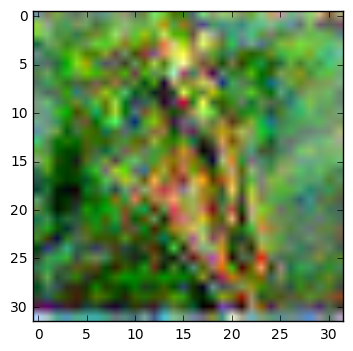

In [18]:
error=[]
for i in range(100):
    if i%10==0:
        print('Start of iteration', i)
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    shilifenxi=evaluator.FFF(x)
    error.append(min_val)

    img = deprocess_image(x.copy())  

    end_time = time.time()

imshow(img)

In [19]:
shilifenxi=np.array(shilifenxi)

In [20]:
shilifenxi.shape

(64, 16, 16)

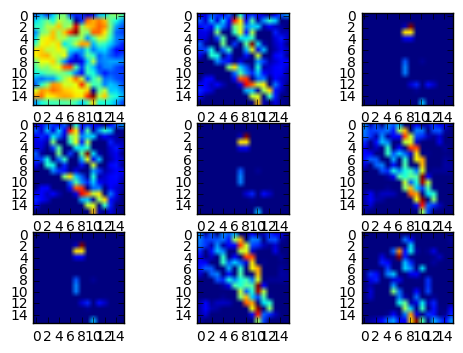

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
sub = plt.subplots(3,3)[1]
for i in range(3):
    for j in range(3):
        plt.axes(sub[i,j])
        imshow(shilifenxi[i+j])




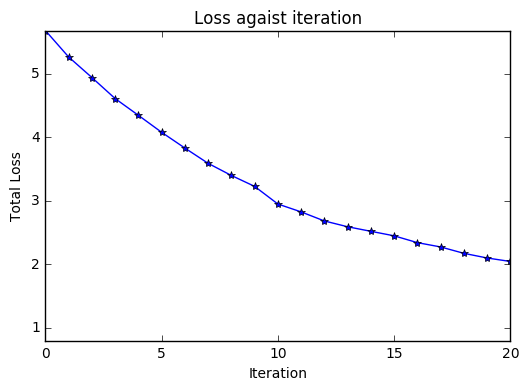

In [22]:
x_axis=range(len(error))
performance = np.array(error)
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.plot(x_axis,performance,'b*-')
plt.axis([0,20,min(error)-0.01,max(error)])
plt.title("Loss agaist iteration")
plt.show()